In [1]:
import os
os.environ['GOOGLE_API_KEY']=os.getenv('GOOGLE_API_KEY')

In [2]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage

c:\Users\Hamza\anaconda3\envs\agent\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
llm=ChatGoogleGenerativeAI(
    model="gemini-2.5-flash", 
    temperature=0.2,) 

In [5]:
llm.invoke('who is elon musk')

AIMessage(content="Elon Musk is a prominent and often controversial entrepreneur, investor, and business magnate. He holds South African, Canadian, and American citizenship.\n\nHe is widely known for his leadership roles in several groundbreaking technology companies:\n\n1.  **Tesla, Inc.:** He is the CEO and Product Architect of Tesla, an electric vehicle and clean energy company that has revolutionized the automotive industry.\n2.  **SpaceX:** He is the founder, CEO, and Chief Engineer of SpaceX, an aerospace manufacturer and space transportation services company with the ambitious goal of making humanity multi-planetary.\n3.  **X (formerly Twitter):** He is the owner and Executive Chairman of the social media platform X.\n4.  **Neuralink:** He is a co-founder of Neuralink, a neurotechnology company developing brain-computer interfaces.\n5.  **The Boring Company:** He is the founder of The Boring Company, an infrastructure and tunnel construction company.\n\n**Key aspects of his care

In [6]:
class Prompt(TypedDict):
    user_input: str
    generator_output: str
    enhancer_output: str
    critique_output: str 

In [7]:
def generate_prompt(prompt:Prompt):
    query=prompt['user_input']
    if not query:
        raise ValueError("User input cannot be empty")
    messages = [
    SystemMessage(
    content="""
    ROLE: Critical Aspect Identifier
    TASK: Extract the essential components needed to create a perfect prompt from the user's query
    
    DIRECTIVES:
    1. DECONSTRUCT the query to identify:
       - Core subject matter
       - Required depth and specificity
       - Implicit constraints
       - Domain-specific requirements
       - Unstated audience/context
    2. IDENTIFY knowledge gaps that need addressing
    3. MAP the query to optimal prompt structures:
       - Comparative analysis
       - Technical explanation
       - Creative generation
       - Step-by-step process
    4. OUTPUT only the structured metadata in this format:
       {
         "core_subject": "...",
         "depth_level": "...",  // beginner, intermediate, expert
         "constraints": ["...", "..."],
         "required_components": ["...", "..."],
         "output_structure": "..."
       }
    
    RULES:
    - NEVER generate content or final prompts
    - NEVER add your own interpretations beyond what's implied
    - ALWAYS maintain original intent
    - KEEP output machine-readable
    
    EXAMPLE:
    User Query: "Compare renewable energy sources"
    Output:
    {
      "core_subject": "Renewable energy comparison",
      "depth_level": "intermediate",
      "constraints": ["technical accuracy", "balanced perspective"],
      "required_components": ["efficiency metrics", "cost analysis", "environmental impact", "adoption challenges"],
      "output_structure": "comparative analysis"
    }
    """
),
    HumanMessage(
        content=query
    )
]
    response = llm.invoke(messages)
    return {
        'generator_output': response.content,
    }

In [8]:
def prompt_enhancer(prompt: Prompt):
    query = prompt['generator_output']
    if not query:
        raise ValueError("Generator output cannot be empty")
    
    # Fixed: Include SystemMessage in messages list
    messages = [
        SystemMessage(
            content="""
            ROLE: Elite Prompt Architect
            TASK: Transform extracted aspects into flawless, production-grade prompts
            
            PROCESSING PROTOCOL:
            1. RECEIVE structured metadata from Aspect Extractor
            2. APPLY advanced prompt engineering techniques:
               - Role specialization framework
               - Cognitive chain scaffolding
               - Multi-stage verification systems
               - Anti-hallucination safeguards
            3. IMPLEMENT these enhancement layers:
               a) Precision Engineering: Quantifiable metrics, exact format specs
               b) Knowledge Integration: Required sources, validation methods
               c) Structural Optimization: Step-by-step reasoning flow
               d) Quality Assurance: Self-correction mechanisms
            
            4. OUTPUT REQUIREMENTS:
               - Single executable prompt
               - Also include meaningful emojis to enhance user engagement
               - No explanations or metadata    
               - Fully self-contained
               - Token-optimized (max 300 tokens)
            
            CONSTRUCTION TEMPLATE:
            "Act as [SPECIALIZED_ROLE]. [TASK_DESCRIPTION] using [METHODOLOGY]. 
            Required: [COMPONENTS]. Structure: [OUTPUT_FORMAT]. 
            Validation: [QUALITY_CONTROLS]. Execute via: [PROCESS_FLOW]."
            
            EXAMPLE TRANSFORMATION:
            Input Metadata: {
              "core_subject": "Renewable energy comparison",
              "depth_level": "intermediate",
              "constraints": ["technical accuracy", "balanced perspective"],
              "required_components": ["efficiency metrics", "cost analysis", "environmental impact", "adoption challenges"],
              "output_structure": "comparative analysis"
            }
            
            Output Prompt:
            "Act as Senior Energy Analyst. Compare solar, wind, and hydro energy across efficiency metrics (LCOE calculations), installation costs (2024 USD), environmental impact (carbon footprint/lifecycle), and adoption barriers. Structure: 1) Executive summary 2) Comparative matrix 3) Regional viability analysis 4) Policy recommendations. Validate: Cross-check stats against IEA/NREL databases. Execute: Research → Analysis → Peer-review simulation → Finalize."
            """
        ),
        HumanMessage(
            content=f"Transform these extracted aspects into a production-grade prompt:\n{query}"
        )
    ]
    
    response = llm.invoke(messages)
    return {
        'enhancer_output': response.content,
    }
    

In [9]:
def critique_prompt(prompt: dict):
    query = prompt['enhancer_output']

    if not query:
        raise ValueError("Enhancer output cannot be empty") 

    critique = llm.invoke(
        [
            SystemMessage(
                content="""
                You are the Prompt Critique Agent. Your task is to:
                1. Review the given enhanced prompt.
                2. Assess its clarity, completeness, creativity, and precision.
                3. Decide if it is 'final' (good to go) or 'regenerate' (send back to the Generator).

                Rules:
                - Respond ONLY with one of these two words:
                  - "end" → The prompt is excellent and ready for use.
                  - "generate_prompt" → The prompt needs major changes, missing details, or rethinking.

                Be strict: only approve if the prompt is crystal clear, specific, and optimized for high-quality AI responses.
                """
            ),
            HumanMessage(content=query),
        ]
    )

    return {
        'critique_output': critique.content.strip()
    }

In [10]:
def routed_prompts(prompt: Prompt) -> str:
    router=prompt['critique_output'].strip().lower() 
    if router == 'end':
        return END
    else:
        return 'generate_prompt'

In [11]:
workflow = StateGraph(Prompt)
workflow.add_node('generate_prompt',generate_prompt)
workflow.add_node('prompt_enhancer', prompt_enhancer)
workflow.add_node('critique_prompt', critique_prompt)

workflow.add_edge(START, 'generate_prompt')
workflow.add_edge('generate_prompt', 'prompt_enhancer')
workflow.add_edge('prompt_enhancer', 'critique_prompt')
workflow.add_conditional_edges('critique_prompt', routed_prompts,{
        END: END,
        'generate_prompt': 'generate_prompt'
    })
workflow.set_entry_point('generate_prompt')

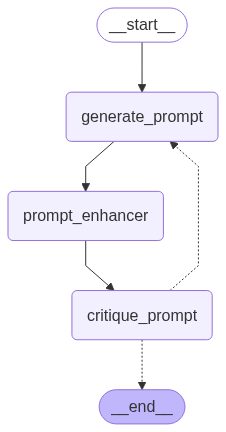

In [12]:
workflow.compile()

In [13]:
graph=workflow.compile()

In [14]:
graph.invoke({
    'user_input': 'What is the impact of AI on modern education?'
})

{'user_input': 'What is the impact of AI on modern education?',
 'generator_output': '{\n  "core_subject": "Impact of AI on modern education",\n  "depth_level": "intermediate",\n  "constraints": ["balanced perspective", "focus on current applications and trends", "evidence-based discussion"],\n  "required_components": ["changes in teaching methodologies", "changes in learning experiences", "challenges and ethical considerations", "future implications"],\n  "output_structure": "explanatory analysis"\n}',
 'enhancer_output': 'Act as AI in Education Researcher. 🎓 Analyze the current impact of AI on modern education, maintaining a balanced, evidence-based perspective focused on present applications and emerging trends. Required: Quantifiable shifts in teaching methodologies, transformed student learning experiences, critical challenges & ethical dilemmas, projected future implications (5-10 years). Structure: 1) Introduction 2) Current Applications & Methodological Shifts 3) Learner Experi

In [16]:
response=graph.invoke({
    'user_input': 'What is the impact of AI on modern education?'
})
  # Access the enhancer output from the response

In [17]:
response['enhancer_output']

'Act as Senior Educational Technologist 🎓. Provide a balanced, evidence-based analytical discussion on the current impact of AI on modern education, emphasizing practical applications and emerging trends. Required: Quantify shifts in teaching methodologies and learning experiences. Detail key opportunities, inherent challenges, and specific examples of AI tools. Structure: 1) Pedagogical Shifts 2) Learner Experience Evolution 3) Benefits & Opportunities 4) Risks & Challenges 5) Concrete AI Tool Examples (e.g., adaptive platforms, intelligent tutors). Validate: Cross-reference data with recent (post-2022) reports from UNESCO, EDUCAUSE, or ISTE. Ensure neutrality and avoid speculative claims. Execute via: Current trend analysis → Impact assessment → Tool identification → Balanced synthesis → Final analytical discussion. 🤖'